In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import jax
import jax.numpy as jnp
from jaxpm.growth import (dGf2a, dGfa, growth_factor, growth_factor_second,
                          growth_rate, growth_rate_second, dGfa, Gf)
from jax import tree
from jax import tree
from jaxpm.pm import pm_forces
from diffrax import ConstantStepSize,  SaveAt, diffeqsolve,StepTo
from jaxpm.plotting import plot_fields_single_projection
from jaxpm.painting import cic_paint , cic_paint_dx
import diffrax
#jax.config.update("jax_enable_x64", True)
import jax
jax.print_environment_info()

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader
%matplotlib inline 


jax:    0.5.2
jaxlib: 0.5.1
numpy:  1.26.4
python: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
device info: Quadro RTX 6000-1, 1 local devices"
process_count: 1
platform: uname_result(system='Linux', node='midway3-0284.rcc.local', release='4.18.0-305.3.1.el8.x86_64', version='#1 SMP Tue Jun 1 16:14:33 UTC 2021', machine='x86_64')


$ nvidia-smi
Mon Apr  7 23:08:34 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+===

/project/chto/chto/anaconda/newenv4/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [2]:
from SuperResPM.configure import Configuration

In [3]:
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('jpeg')


In [4]:
from SuperResPM.diffrax_helper import FPMODE,FPMLeapFrog,symplectic_ode

In [5]:
cosmo_in = [0.3175, 0.049, 0.6711, 0.9624, 0.834]#Omega_m                 Omega_b                  h                        n_s                      sigma_8
import jax_cosmo as jc
from diffrax import ConstantStepSize
from jaxpm.pm import linear_field, lpt

# Tutorial 

In this set of code, I add a fastPM-like leapfrog solver to diffrax. This solver also allows a gradient calculation with the reversible adjoint method.  

The API should be similar to jaxpm with standard diffrax solver. 

Some additonal modification of APT details below:

- This code declares the solver. 
>>>

        ode_fn = tree.map(
                FPMODE,
                symplectic_ode(mesh_shape, paint_absolute_pos=paint_absolute_pos>0)
        )
        solver = FPMLeapFrog(initial_t0=initial_t0, final_t1=final_time)
        

-  In addition to dx and p, we also need the initial force (or acceleration) at the start point. You can get it with pm_force in jaxpm.
   Note that the calculation can be slightly different depending on whether you do absolute position or relative position. 
>>>
        if paint_absolute_pos>0:
            initforce = pm_forces(
                particles+dx,
                mesh_shape=mesh_shape,
                paint_absolute_pos=paint_absolute_pos>0,
            )* 1.5* cosmo.Omega_m
        else:
            initforce = pm_forces(
                dx,
                mesh_shape=mesh_shape,
                paint_absolute_pos=paint_absolute_pos>0,
            )* 1.5* cosmo.Omega_m        
        if paint_absolute_pos>0:
            y0= jnp.stack([particles+dx, p,initforce], axis=0)
        else:
            y0= jnp.stack([dx, p,initforce], axis=0)

- Also, since jax_cosmo is not a pure function, we have to initialize it first. 

  >>>
    cosmo = jc.Cosmology(Omega_c=cosmo_in[0]-cosmo_in[1], Omega_b=cosmo_in[1], h=cosmo_in[2], sigma8 = cosmo_in[4], n_s=cosmo_in[3],
                      Omega_k=0., w0=-1., wa=0.)
    ain=np.atleast_1d(1)
    _ =  growth_rate_second(cosmo,ain)
    _ = growth_rate(cosmo, ain)
    _ = growth_factor(cosmo, ain)
    jc.background.radial_comoving_distance(cosmo, ain)
  >>>

- Finally, we can just do the ordinary diffeqsolve. Note that the args value has two zeroes at the end. Those are for bookkeeping reasons. You can put whatever value you want. 
>>>
        res = diffeqsolve(ode_fn,solver,\
                      t0=initial_t0,\
                      t1=final_time,\
                      dt0=dt0,\
                      y0=y0,
                      args=[cosmo, cosmo._workspace, initial_t0, conf, 0, 0],\
                      saveat=SaveAt(t1=True),
                      stepsize_controller=stepsize_controller,adjoint=diffrax.ReversibleAdjoint())


### Content in this notebook. 
To test the implementation, I did the following tests 
- 1. Running code two times to test reproducibility
  2. Running code forward and backward to test reversibility, which is important for gradient calculation. 
  3. Optimizing the code to produce faspm universe. This is to check that the overall gradient makes sense.
  4. Check against nbosy simulation (Qujote) to make sure that the cosmology calculation is valid.  

# Test reproducibility

In [6]:
def check_reproducibility(
        nmesh,
        da,
        seed=0,
        paint_absolute_pos=0
    ):


    conf = Configuration(mesh_shape=[nmesh, nmesh, nmesh], 
                     snapshots= [1],
                     BoxSize=[256,256,256], 
                     initial_t0=1/64,
                     final_time = 1,
                     density_plane_npix = nmesh,
                     dt0=da,
                     density_plane_width= 100.0
                    )
    cosmo = jc.Cosmology(Omega_c=cosmo_in[0]-cosmo_in[1], Omega_b=cosmo_in[1], h=cosmo_in[2], sigma8 = cosmo_in[4], n_s=cosmo_in[3],
                      Omega_k=0., w0=-1., wa=0.)
    ain=np.atleast_1d(1)
    _ =  growth_rate_second(cosmo,ain)
    _ = growth_rate(cosmo, ain)
    _ = growth_factor(cosmo, ain)
    jc.background.radial_comoving_distance(cosmo, ain)
    
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in conf.mesh_shape]),axis=-1).reshape([-1,3])
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmo, k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)
    # Create initial conditions and particle
    initial_conditions = linear_field(conf.mesh_shape, conf.BoxSize, pk_fn, seed=jax.random.PRNGKey(seed))
    #@jax.jit
    def model(initial_conditions, cosmo, conf, particles,paint_absolute_pos):
        mesh_shape = conf.mesh_shape
        initial_t0 = conf.initial_t0
        final_time = conf.final_time
        snapshots = conf.snapshots
        nmesh = conf.mesh_shape[0]
        dt0 = conf.dt0
        if paint_absolute_pos>0:
            dx, p, f = lpt(cosmo, initial_conditions, particles, a=conf.initial_t0)
        else:
            dx, p, f = lpt(cosmo, initial_conditions, a=conf.initial_t0)
        ode_fn = tree.map(
                FPMODE,
                symplectic_ode(mesh_shape, paint_absolute_pos=paint_absolute_pos>0)
        )
        solver = FPMLeapFrog(initial_t0=initial_t0, final_t1=final_time)

        stepsize_controller = ConstantStepSize()
        if paint_absolute_pos>0:
            initforce = pm_forces(
                particles+dx,
                mesh_shape=mesh_shape,
                paint_absolute_pos=paint_absolute_pos>0,
            )* 1.5* cosmo.Omega_m
        else:
            initforce = pm_forces(
                dx,
                mesh_shape=mesh_shape,
                paint_absolute_pos=paint_absolute_pos>0,
            )* 1.5* cosmo.Omega_m        
        if paint_absolute_pos>0:
            y0= jnp.stack([particles+dx, p,initforce], axis=0)
        else:
            y0= jnp.stack([dx, p,initforce], axis=0)
        res = diffeqsolve(ode_fn,solver,\
                      t0=initial_t0,\
                      t1=final_time,\
                      dt0=dt0,\
                      y0=y0,
                      args=[cosmo, cosmo._workspace, initial_t0, conf, 0, 0],\
                      saveat=SaveAt(t1=True),
                      stepsize_controller=stepsize_controller,adjoint=diffrax.ReversibleAdjoint())
        return res
    p1 = model(initial_conditions, cosmo, conf, particles, paint_absolute_pos).ys
    p2 = model(initial_conditions, cosmo, conf, particles, paint_absolute_pos).ys
    diffpos = np.std(p1[0,0].flatten()-p2[0,0].flatten())/np.std(p1[0,0].flatten())
    diffvel = np.std(p1[0,1].flatten()-p2[0,1].flatten())/np.std(p1[0,1].flatten())
    print(f"nmesh: {nmesh}, timestep: {da :3}", f'rel error in pos: {diffpos}, vel:{diffvel}')
    return p1, p2


In [7]:
nmesh=64
conf = Configuration(mesh_shape=[nmesh, nmesh, nmesh], 
                     snapshots= [1],
                     BoxSize=[256,256,256], 
                     initial_t0=1/64,
                     final_time = 1,
                     density_plane_npix = nmesh,
                     dt0=0.1,
                     density_plane_width= 100.0
                    )

In [8]:
particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in conf.mesh_shape]),axis=-1).reshape([-1,3])

In [9]:
p1, p2 = check_reproducibility(nmesh=64, da=0.01, paint_absolute_pos=1)

/project/chto/chto/anaconda/newenv4/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


nmesh: 64, timestep: 0.01 rel error in pos: 8.212267488261205e-08, vel:8.853220379023696e-07


In [10]:
p3,p4 = check_reproducibility(nmesh=64, da=0.01, paint_absolute_pos=0)

nmesh: 64, timestep: 0.01 rel error in pos: 2.9673419703613035e-05, vel:5.507774039870128e-05


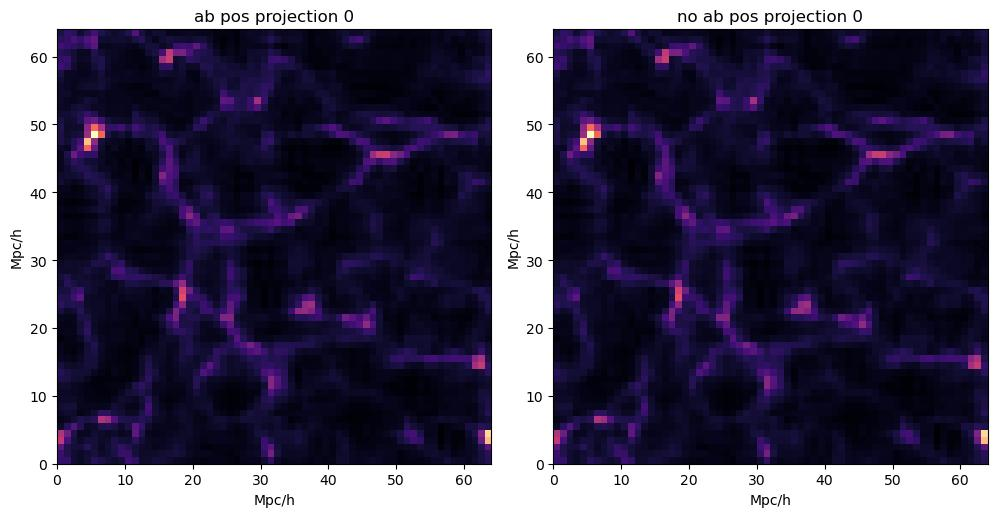

In [11]:
mesh_shape = [64,64,64]

fields = {"ab pos" : cic_paint(jnp.zeros(mesh_shape),p1[0][0]),"no ab pos" : cic_paint_dx(p3[0][0])}
plot_fields_single_projection(fields)

# Test Reversibility

In [12]:
def check_reverse(
        nmesh,
        da,
        seed=0,
        paint_absolute_pos=0
    ):


    conf = Configuration(mesh_shape=[nmesh, nmesh, nmesh], 
                     snapshots= [1],
                     BoxSize=[256,256,256], 
                     initial_t0=1/64.,
                     final_time = 1.0,
                     density_plane_npix = nmesh,
                     dt0=da,
                     density_plane_width= 100.0
            )
    conf_inv = Configuration(mesh_shape=[nmesh, nmesh, nmesh], 
                     snapshots= [1],
                     BoxSize=[256,256,256], 
                     initial_t0=1.0,
                     final_time =1/64.,
                     density_plane_npix = nmesh,
                     dt0=-1*da,
                     density_plane_width= 100.0
             )
    cosmo = jc.Cosmology(Omega_c=cosmo_in[0]-cosmo_in[1], Omega_b=cosmo_in[1], h=cosmo_in[2], sigma8 = cosmo_in[4], n_s=cosmo_in[3],
                      Omega_k=0., w0=-1., wa=0.)
    ain = np.atleast_1d(1)
    _ =  growth_rate_second(cosmo,ain)
    _ = growth_rate(cosmo, ain)
    _ = growth_factor(cosmo, ain)
    jc.background.radial_comoving_distance(cosmo, ain)
    
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in conf.mesh_shape]),axis=-1).reshape([-1,3])
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmo, k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)
    
    # Create initial conditions and particle
    initial_conditions = linear_field(conf.mesh_shape, conf.BoxSize, pk_fn, seed=jax.random.PRNGKey(seed))
    #@jax.jit
    def model(initial_conditions, cosmo, conf, conf_inv, particles,paint_absolute_pos):
        mesh_shape = conf.mesh_shape
        initial_t0 = conf.initial_t0
        final_time = conf.final_time
        snapshots = conf.snapshots
        nmesh = conf.mesh_shape[0]
        dt0 = conf.dt0
        if paint_absolute_pos>0:
            dx, p, f = lpt(cosmo, initial_conditions, particles, a=conf.initial_t0)
        else:
            dx, p, f = lpt(cosmo, initial_conditions, a=conf.initial_t0)
        ode_fn = tree.map(
                FPMODE,
                symplectic_ode(mesh_shape, paint_absolute_pos=paint_absolute_pos>0)
        )
        solver = FPMLeapFrog(initial_t0=initial_t0, final_t1=final_time)
        solver_rev = FPMLeapFrog(initial_t0=final_time, final_t1=initial_t0)

        if paint_absolute_pos>0:
            initforce = pm_forces(
                particles+dx,
                mesh_shape=mesh_shape,
                paint_absolute_pos=paint_absolute_pos>0,
            )* 1.5* cosmo.Omega_m
        else:
            initforce = pm_forces(
                dx,
                mesh_shape=mesh_shape,
                paint_absolute_pos=paint_absolute_pos>0,
            )* 1.5* cosmo.Omega_m        
        if paint_absolute_pos>0:
            y0= jnp.stack([particles+dx, p,initforce], axis=0)
        else:
            y0= jnp.stack([dx, p,initforce], axis=0)


        step_num=jnp.ceil((conf.final_time - conf.initial_t0) / dt0)
        tseris = np.linspace(conf.initial_t0,conf.final_time, num=1+int(step_num))
        
        tseris_inv = tseris[::-1]
        stepsize_controller = StepTo(tseris)
        stepsize_controller_inv = StepTo(tseris_inv)

        res = diffeqsolve(ode_fn,solver,\
                      t0=initial_t0,\
                      t1=final_time,\
                      dt0=None,\
                      y0=y0,
                      args=[cosmo, cosmo._workspace, initial_t0, conf, 0, 0],\
                      saveat=SaveAt(ts=[final_time]),
                      stepsize_controller=stepsize_controller,adjoint=diffrax.ReversibleAdjoint())
        
        res2 = diffeqsolve(ode_fn,solver_rev ,\
                      t0=final_time,\
                      t1=initial_t0,\
                      dt0=None,\
                      y0=res.ys[0],
                      args=[cosmo, cosmo._workspace, final_time, conf_inv, 0, 0],\
                      saveat=SaveAt(ts=[initial_t0]),
                      stepsize_controller=stepsize_controller_inv,adjoint=diffrax.ReversibleAdjoint())
        
        return res2, res,y0
        
    p1old, p11, p2 = model(initial_conditions, cosmo, conf, conf_inv,particles, paint_absolute_pos)
    p1 = p1old.ys[0]
    diffpos = np.std(p1[0].flatten()-p2[0].flatten())/np.std(p1[0].flatten())
    diffvel = np.std(p1[1].flatten()-p2[1].flatten())/np.std(p1[1].flatten())
    print(f"nmesh: {nmesh}, timestep: {da :3}", f'rel error in pos: {diffpos}, vel:{diffvel}')
    return p1old, p11,p2


In [13]:
backward, middle, init = check_reverse(nmesh=64, da=0.01, paint_absolute_pos=0)

/project/chto/chto/anaconda/newenv4/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


nmesh: 64, timestep: 0.01 rel error in pos: 0.0019095763564109802, vel:0.011073867790400982


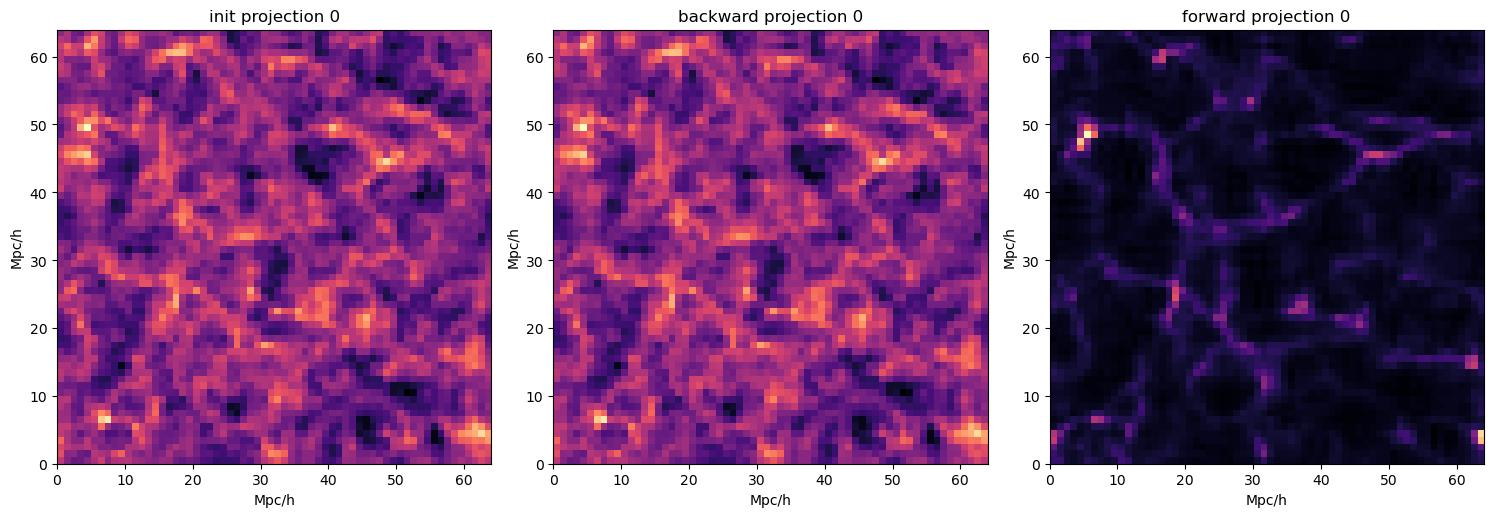

In [14]:
fields = {"init" : cic_paint_dx(init[0]), "backward" : cic_paint_dx(backward.ys[0][0]), "forward" : cic_paint_dx(middle.ys[0][0])}
plot_fields_single_projection(fields)

# Check whether I can produce jaxpm universe

In [6]:
from PIL import Image, ImageFont, ImageDraw
nmesh=256

text = 'jaxpm'

ptcl_spacing = 10.
ptcl_grid_shape = (nmesh, nmesh, nmesh)
mesh_shape = (nmesh,nmesh,nmesh)
im_shape = (nmesh,nmesh)
xy = (int(nmesh/2), int(nmesh/2))

im = Image.new('L', im_shape[::-1], 255)
draw = ImageDraw.Draw(im)
fontsize=20
draw.text(xy, text, anchor='mm',font = ImageFont.truetype("/home/chto/code/pmwd/docs/nova/NovaRoundSlim-BookOblique.ttf",size=80)
)

# normalize the image to make the target
im_tgt = 1 - jnp.asarray(im) / 255
im_tgt *= jnp.prod(jnp.array(ptcl_grid_shape)) / im_tgt.sum()
im_tgt= im_tgt/im_tgt.sum()-1


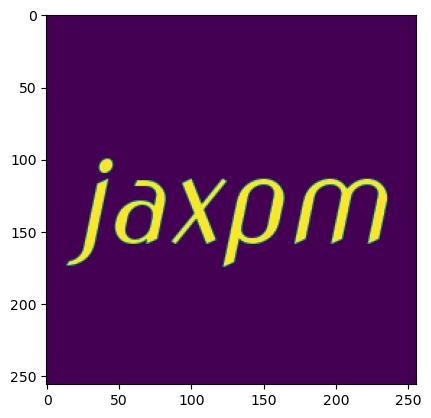

In [7]:
plt.imshow(im_tgt)

In [8]:
from jaxpm.painting import cic_paint_2d
def density_plane_fn(t, y, args):
    cosmo, config = args
    positions = y
    nc = config.mesh_shape
    nx, ny, nz = nc
    density_plane_npix= config.density_plane_npix
    density_plane_width = config.density_plane_width
    # Converts time t to comoving distance in voxel coordinates
    w = density_plane_width /config.BoxSize[2] * nc[2]
    center = 16 #jc.background.radial_comoving_distance(cosmo, t) / config['BoxSize'][2] * nc[2]

    xy = positions[..., :2]
    d = positions[..., 2]

    # Apply 2d periodic conditions
    xy = jnp.mod(xy, nx)

    # Rescaling positions to target grid
    xy = xy / nx * density_plane_npix

    # Selecting only particles that fall inside the volume of interest
    weight = jnp.where((d > (center - w / 2)) & (d <= (center + w / 2)), 1., 0.)

    # Painting density plane
    density_plane = cic_paint_2d(jnp.zeros([density_plane_npix, density_plane_npix]), xy, weight)

    # Apply density normalization
    density_plane = density_plane / ((nx / density_plane_npix) *
                                     (ny / density_plane_npix) * w)

    return density_plane
import equinox as eqx


In [9]:
nmesh = 256
da = 0.1
seed=0 


conf = Configuration(mesh_shape=[nmesh, nmesh, nmesh], 
                 snapshots= [1],
                 BoxSize=[256,256,256], 
                 initial_t0=1/64,
                 final_time = 1,
                 density_plane_npix = nmesh,
                 dt0=da,
                 density_plane_width= 100.0
                )
cosmo = jc.Cosmology(Omega_c=cosmo_in[0]-cosmo_in[1], Omega_b=cosmo_in[1], h=cosmo_in[2], sigma8 = cosmo_in[4], n_s=cosmo_in[3],
                  Omega_k=0., w0=-1., wa=0.)
ain=np.atleast_1d(1)
_ =  growth_rate_second(cosmo,ain)
_ = growth_rate(cosmo, ain)
_ = growth_factor(cosmo, ain)
jc.background.radial_comoving_distance(cosmo, ain)

k = jnp.logspace(-4, 1, 128)
pk = jc.power.linear_matter_power(cosmo, k)
pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)
# Create initial conditions and particle
initial_conditions = linear_field(conf.mesh_shape, conf.BoxSize, pk_fn, seed=jax.random.PRNGKey(seed))
@jax.jit
def model(initial_conditions, cosmo, conf,):
    mesh_shape = conf.mesh_shape
    initial_t0 = conf.initial_t0
    final_time = conf.final_time
    snapshots = conf.snapshots
    nmesh = conf.mesh_shape[0]
    dt0 = conf.dt0
    dx, p, f = lpt(cosmo, initial_conditions, a=conf.initial_t0)
    ode_fn = tree.map(
            FPMODE,
            symplectic_ode(mesh_shape, paint_absolute_pos=False)
    )
    solver = FPMLeapFrog(initial_t0=initial_t0, final_t1=final_time)
    stepsize_controller = ConstantStepSize()

    initforce = pm_forces(
        dx,
        mesh_shape=mesh_shape,
        paint_absolute_pos=False,
    )* 1.5* cosmo.Omega_m        
    
    y0= jnp.stack([dx, p,initforce], axis=0)
    res = diffeqsolve(ode_fn,solver,\
                  t0=initial_t0,\
                  t1=final_time,\
                  dt0=dt0,\
                  y0=y0,
                  args=[cosmo, cosmo._workspace, initial_t0, conf, 0, 0],\
                  saveat=SaveAt(t1=True),
                  stepsize_controller=stepsize_controller,adjoint=diffrax.ReversibleAdjoint())

    a, b, c = jnp.meshgrid(jnp.arange(conf.mesh_shape[0]),
                           jnp.arange(conf.mesh_shape[1]),
                           jnp.arange(conf.mesh_shape[2]),
                           indexing='ij')
    pmid = jnp.stack([a , b , c], axis=-1)
    
    res2 = density_plane_fn(res.ts[-1], (pmid+res.ys[0][0]).reshape(-1,3), [cosmo,conf])
    return res2/np.sum(res2)-1
p1 = model(initial_conditions, cosmo, conf)


/project/chto/chto/anaconda/newenv4/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


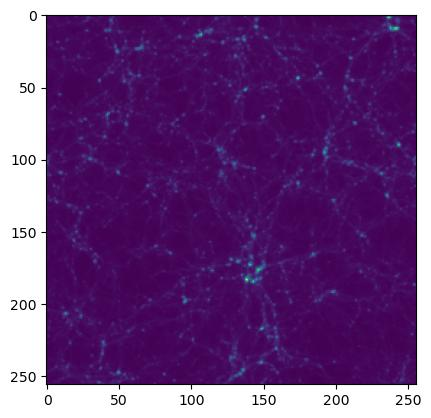

In [10]:
plt.imshow(p1)

In [11]:
from tqdm import tqdm
from jax.example_libraries.optimizers import adam
from jax import value_and_grad
def obj(initial_conditions):
    dens = model(initial_conditions, cosmo, conf)
    
    return (dens - im_tgt).var() / im_tgt.var()
    
obj_valgrad = jax.jit(jax.value_and_grad(obj))

In [13]:
%prun obj_valgrad(initial_conditions)

         1869 function calls (1867 primitive calls) in 2.698 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    2.520    2.520    2.520    2.520 pxla.py:1277(__call__)
        1    0.176    0.176    0.176    0.176 pxla.py:2649(_get_layouts_from_executable)
        3    0.000    0.000    0.000    0.000 {built-in method fromkeys}
        1    0.000    0.000    0.000    0.000 pxla.py:2464(get_out_shardings_from_executable)
        1    0.000    0.000    0.001    0.001 pxla.py:2208(lower_sharding_computation)
     1032    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
        1    0.000    0.000    0.176    0.176 pxla.py:2899(from_hlo)
        1    0.000    0.000    0.000    0.000 pjit.py:701(_infer_params)
        1    0.000    0.000    0.000    0.000 pxla.py:1725(_get_and_check_device_assignment)
        1    0.000    0.000    2.698    2.698 <string>:1(<module>)
      188    0.000    0.000   

In [14]:
#Check runtime and memory
#%prun obj_valgrad(initial_conditions)
#with jax.profiler.trace("tensorborard/"):
#    _,_ =obj_valgrad(initial_conditions)#.block_until_ready()


In [15]:
cpu_device = jax.devices('cpu')[0]

In [16]:
from tqdm import tqdm
from jax.example_libraries.optimizers import adam
from jax import value_and_grad
def optim(tgt, initial_conditions, cosmo, conf, iters=100, lr=0.1):
    init, update, get_params = adam(lr)
    state = init(initial_conditions)
    #@jax.jit
    def step(i, state, tgt, cosmo, conf):
        initial_conditions = get_params(state)
        value, grads = obj_valgrad(initial_conditions)
        state = update(i, grads, state)
        jax.debug.print("{y} loss {x}", x=value, y=i)
        return value, state
    tgt = jnp.asarray(tgt)
    
    initall = []
    for i in tqdm(range(iters)):
        value, state = step(i, state, tgt, cosmo, conf)
        initall.append(jax.jit(get_params, device=cpu_device)(state))
        #jax.clear_caches() 
    initial_conditions = get_params(state)
    return value, initial_conditions, initall

In [17]:
loss, initial_conditions_optim, initall = optim(im_tgt, initial_conditions, cosmo, conf, iters=500)
loss, initial_conditions.std(), initial_conditions_optim.std()

  0%|▎                                                                                                                                                                                | 1/500 [00:03<26:09,  3.14s/it]

0 loss 1.090367317199707


  0%|▋                                                                                                                                                                                | 2/500 [00:05<24:31,  2.96s/it]

1 loss 1.0633419752120972


  1%|█                                                                                                                                                                                | 3/500 [00:08<23:58,  2.89s/it]

2 loss 1.045209527015686


  1%|█▍                                                                                                                                                                               | 4/500 [00:11<23:42,  2.87s/it]

3 loss 1.0295987129211426


  1%|█▊                                                                                                                                                                               | 5/500 [00:14<23:32,  2.85s/it]

4 loss 1.0146608352661133


  1%|██                                                                                                                                                                               | 6/500 [00:17<23:24,  2.84s/it]

5 loss 1.0006753206253052


  1%|██▍                                                                                                                                                                              | 7/500 [00:20<23:19,  2.84s/it]

6 loss 0.9858233332633972


  2%|██▊                                                                                                                                                                              | 8/500 [00:22<23:13,  2.83s/it]

7 loss 0.9709124565124512


  2%|███▏                                                                                                                                                                             | 9/500 [00:25<23:09,  2.83s/it]

8 loss 0.9578410983085632


  2%|███▌                                                                                                                                                                            | 10/500 [00:28<23:06,  2.83s/it]

9 loss 0.946280300617218


  2%|███▊                                                                                                                                                                            | 11/500 [00:31<23:03,  2.83s/it]

10 loss 0.9352635145187378


  2%|████▏                                                                                                                                                                           | 12/500 [00:34<22:59,  2.83s/it]

11 loss 0.9243565201759338


  3%|████▌                                                                                                                                                                           | 13/500 [00:37<22:56,  2.83s/it]

12 loss 0.9125955700874329


  3%|████▉                                                                                                                                                                           | 14/500 [00:39<22:53,  2.83s/it]

13 loss 0.9005900025367737


  3%|█████▎                                                                                                                                                                          | 15/500 [00:42<22:51,  2.83s/it]

14 loss 0.8898316025733948


  3%|█████▋                                                                                                                                                                          | 16/500 [00:45<22:47,  2.83s/it]

15 loss 0.8802164793014526


  3%|█████▉                                                                                                                                                                          | 17/500 [00:48<22:43,  2.82s/it]

16 loss 0.870062530040741


  4%|██████▎                                                                                                                                                                         | 18/500 [00:51<22:41,  2.82s/it]

17 loss 0.8604196310043335


  4%|██████▋                                                                                                                                                                         | 19/500 [00:53<22:37,  2.82s/it]

18 loss 0.8506972193717957


  4%|███████                                                                                                                                                                         | 20/500 [00:56<22:34,  2.82s/it]

19 loss 0.8402960896492004


  4%|███████▍                                                                                                                                                                        | 21/500 [00:59<22:32,  2.82s/it]

20 loss 0.8302951455116272


  4%|███████▋                                                                                                                                                                        | 22/500 [01:02<22:30,  2.82s/it]

21 loss 0.8211338520050049


  5%|████████                                                                                                                                                                        | 23/500 [01:05<22:26,  2.82s/it]

22 loss 0.8126480579376221


  5%|████████▍                                                                                                                                                                       | 24/500 [01:08<22:24,  2.82s/it]

23 loss 0.8047407269477844


  5%|████████▊                                                                                                                                                                       | 25/500 [01:10<22:23,  2.83s/it]

24 loss 0.7968543171882629


  5%|█████████▏                                                                                                                                                                      | 26/500 [01:13<22:20,  2.83s/it]

25 loss 0.789260983467102


  5%|█████████▌                                                                                                                                                                      | 27/500 [01:16<22:16,  2.83s/it]

26 loss 0.7826585173606873


  6%|█████████▊                                                                                                                                                                      | 28/500 [01:19<22:13,  2.83s/it]

27 loss 0.7761842012405396


  6%|██████████▏                                                                                                                                                                     | 29/500 [01:22<22:10,  2.83s/it]

28 loss 0.7695777416229248


  6%|██████████▌                                                                                                                                                                     | 30/500 [01:25<22:08,  2.83s/it]

29 loss 0.763029932975769


  6%|██████████▉                                                                                                                                                                     | 31/500 [01:27<22:05,  2.83s/it]

30 loss 0.7565602660179138


  6%|███████████▎                                                                                                                                                                    | 32/500 [01:30<22:03,  2.83s/it]

31 loss 0.7504663467407227


  7%|███████████▌                                                                                                                                                                    | 33/500 [01:33<21:59,  2.83s/it]

32 loss 0.7446191906929016


  7%|███████████▉                                                                                                                                                                    | 34/500 [01:36<21:57,  2.83s/it]

33 loss 0.7388617396354675


  7%|████████████▎                                                                                                                                                                   | 35/500 [01:39<21:53,  2.82s/it]

34 loss 0.7330236434936523


  7%|████████████▋                                                                                                                                                                   | 36/500 [01:42<21:50,  2.82s/it]

35 loss 0.7270017266273499


  7%|█████████████                                                                                                                                                                   | 37/500 [01:44<21:48,  2.83s/it]

36 loss 0.721198558807373


  8%|█████████████▍                                                                                                                                                                  | 38/500 [01:47<21:46,  2.83s/it]

37 loss 0.7159629464149475


  8%|█████████████▋                                                                                                                                                                  | 39/500 [01:50<21:43,  2.83s/it]

38 loss 0.7104490995407104


  8%|██████████████                                                                                                                                                                  | 40/500 [01:53<21:40,  2.83s/it]

39 loss 0.7046354413032532


  8%|██████████████▍                                                                                                                                                                 | 41/500 [01:56<21:37,  2.83s/it]

40 loss 0.6992689967155457


  8%|██████████████▊                                                                                                                                                                 | 42/500 [01:58<21:35,  2.83s/it]

41 loss 0.6939848065376282


  9%|███████████████▏                                                                                                                                                                | 43/500 [02:01<21:32,  2.83s/it]

42 loss 0.6889059543609619


  9%|███████████████▍                                                                                                                                                                | 44/500 [02:04<21:29,  2.83s/it]

43 loss 0.6837449669837952


  9%|███████████████▊                                                                                                                                                                | 45/500 [02:07<21:28,  2.83s/it]

44 loss 0.6788484454154968


  9%|████████████████▏                                                                                                                                                               | 46/500 [02:10<21:26,  2.83s/it]

45 loss 0.6737843751907349


  9%|████████████████▌                                                                                                                                                               | 47/500 [02:13<21:22,  2.83s/it]

46 loss 0.6685346961021423


 10%|████████████████▉                                                                                                                                                               | 48/500 [02:15<21:19,  2.83s/it]

47 loss 0.663254976272583


 10%|█████████████████▏                                                                                                                                                              | 49/500 [02:18<21:17,  2.83s/it]

48 loss 0.658395528793335


 10%|█████████████████▌                                                                                                                                                              | 50/500 [02:21<21:15,  2.83s/it]

49 loss 0.6536766886711121


 10%|█████████████████▉                                                                                                                                                              | 51/500 [02:24<21:11,  2.83s/it]

50 loss 0.6487855315208435


 10%|██████████████████▎                                                                                                                                                             | 52/500 [02:27<21:08,  2.83s/it]

51 loss 0.6439735889434814


 11%|██████████████████▋                                                                                                                                                             | 53/500 [02:30<21:06,  2.83s/it]

52 loss 0.6388628482818604


 11%|███████████████████                                                                                                                                                             | 54/500 [02:32<21:04,  2.83s/it]

53 loss 0.6338284015655518


 11%|███████████████████▎                                                                                                                                                            | 55/500 [02:35<21:00,  2.83s/it]

54 loss 0.6288179159164429


 11%|███████████████████▋                                                                                                                                                            | 56/500 [02:38<20:58,  2.83s/it]

55 loss 0.6236178874969482


 11%|████████████████████                                                                                                                                                            | 57/500 [02:41<20:54,  2.83s/it]

56 loss 0.6186352968215942


 12%|████████████████████▍                                                                                                                                                           | 58/500 [02:44<20:51,  2.83s/it]

57 loss 0.6138918399810791


 12%|████████████████████▊                                                                                                                                                           | 59/500 [02:47<20:48,  2.83s/it]

58 loss 0.6093277335166931


 12%|█████████████████████                                                                                                                                                           | 60/500 [02:49<20:46,  2.83s/it]

59 loss 0.6048154234886169


 12%|█████████████████████▍                                                                                                                                                          | 61/500 [02:52<20:44,  2.84s/it]

60 loss 0.6001509428024292


 12%|█████████████████████▊                                                                                                                                                          | 62/500 [02:55<20:42,  2.84s/it]

61 loss 0.5956290364265442


 13%|██████████████████████▏                                                                                                                                                         | 63/500 [02:58<20:39,  2.84s/it]

62 loss 0.5915685892105103


 13%|██████████████████████▌                                                                                                                                                         | 64/500 [03:01<20:36,  2.84s/it]

63 loss 0.5878387093544006


 13%|██████████████████████▉                                                                                                                                                         | 65/500 [03:04<20:33,  2.84s/it]

64 loss 0.5839881300926208


 13%|███████████████████████▏                                                                                                                                                        | 66/500 [03:07<20:30,  2.84s/it]

65 loss 0.5802189707756042


 13%|███████████████████████▌                                                                                                                                                        | 67/500 [03:09<20:28,  2.84s/it]

66 loss 0.5764337778091431


 14%|███████████████████████▉                                                                                                                                                        | 68/500 [03:12<20:25,  2.84s/it]

67 loss 0.5727868676185608


 14%|████████████████████████▎                                                                                                                                                       | 69/500 [03:15<20:22,  2.84s/it]

68 loss 0.5695176720619202


 14%|████████████████████████▋                                                                                                                                                       | 70/500 [03:18<20:20,  2.84s/it]

69 loss 0.5664553642272949


 14%|████████████████████████▉                                                                                                                                                       | 71/500 [03:21<20:17,  2.84s/it]

70 loss 0.5635437965393066


 14%|█████████████████████████▎                                                                                                                                                      | 72/500 [03:24<20:15,  2.84s/it]

71 loss 0.560016930103302


 15%|█████████████████████████▋                                                                                                                                                      | 73/500 [03:26<20:12,  2.84s/it]

72 loss 0.5558573603630066


 15%|██████████████████████████                                                                                                                                                      | 74/500 [03:29<20:09,  2.84s/it]

73 loss 0.5527053475379944


 15%|██████████████████████████▍                                                                                                                                                     | 75/500 [03:32<20:05,  2.84s/it]

74 loss 0.5500802397727966


 15%|██████████████████████████▊                                                                                                                                                     | 76/500 [03:35<20:03,  2.84s/it]

75 loss 0.5474867820739746


 15%|███████████████████████████                                                                                                                                                     | 77/500 [03:38<20:01,  2.84s/it]

76 loss 0.5445327758789062


 16%|███████████████████████████▍                                                                                                                                                    | 78/500 [03:41<20:00,  2.84s/it]

77 loss 0.5407780408859253


 16%|███████████████████████████▊                                                                                                                                                    | 79/500 [03:43<19:57,  2.84s/it]

78 loss 0.537581205368042


 16%|████████████████████████████▏                                                                                                                                                   | 80/500 [03:46<19:54,  2.84s/it]

79 loss 0.5351647734642029


 16%|████████████████████████████▌                                                                                                                                                   | 81/500 [03:49<19:50,  2.84s/it]

80 loss 0.5325737595558167


 16%|████████████████████████████▊                                                                                                                                                   | 82/500 [03:52<19:49,  2.84s/it]

81 loss 0.5301016569137573


 17%|█████████████████████████████▏                                                                                                                                                  | 83/500 [03:55<19:46,  2.85s/it]

82 loss 0.5272460579872131


 17%|█████████████████████████████▌                                                                                                                                                  | 84/500 [03:58<19:44,  2.85s/it]

83 loss 0.5236768126487732


 17%|█████████████████████████████▉                                                                                                                                                  | 85/500 [04:01<19:41,  2.85s/it]

84 loss 0.5206641554832458


 17%|██████████████████████████████▎                                                                                                                                                 | 86/500 [04:03<19:39,  2.85s/it]

85 loss 0.5185787081718445


 17%|██████████████████████████████▌                                                                                                                                                 | 87/500 [04:06<19:35,  2.85s/it]

86 loss 0.5163140892982483


 18%|██████████████████████████████▉                                                                                                                                                 | 88/500 [04:09<19:33,  2.85s/it]

87 loss 0.5140685439109802


 18%|███████████████████████████████▎                                                                                                                                                | 89/500 [04:12<19:30,  2.85s/it]

88 loss 0.5120940804481506


 18%|███████████████████████████████▋                                                                                                                                                | 90/500 [04:15<19:27,  2.85s/it]

89 loss 0.5098937749862671


 18%|████████████████████████████████                                                                                                                                                | 91/500 [04:18<19:24,  2.85s/it]

90 loss 0.5073598027229309


 18%|████████████████████████████████▍                                                                                                                                               | 92/500 [04:20<19:21,  2.85s/it]

91 loss 0.5047523379325867


 19%|████████████████████████████████▋                                                                                                                                               | 93/500 [04:23<19:19,  2.85s/it]

92 loss 0.502526581287384


 19%|█████████████████████████████████                                                                                                                                               | 94/500 [04:26<19:17,  2.85s/it]

93 loss 0.5004652738571167


 19%|█████████████████████████████████▍                                                                                                                                              | 95/500 [04:29<19:13,  2.85s/it]

94 loss 0.4979912042617798


 19%|█████████████████████████████████▊                                                                                                                                              | 96/500 [04:32<19:11,  2.85s/it]

95 loss 0.49580109119415283


 19%|██████████████████████████████████▏                                                                                                                                             | 97/500 [04:35<19:08,  2.85s/it]

96 loss 0.4938182830810547


 20%|██████████████████████████████████▍                                                                                                                                             | 98/500 [04:38<19:06,  2.85s/it]

97 loss 0.4913618564605713


 20%|██████████████████████████████████▊                                                                                                                                             | 99/500 [04:40<19:02,  2.85s/it]

98 loss 0.4892450273036957


 20%|███████████████████████████████████                                                                                                                                            | 100/500 [04:43<19:00,  2.85s/it]

99 loss 0.4871169924736023


 20%|███████████████████████████████████▎                                                                                                                                           | 101/500 [04:46<18:57,  2.85s/it]

100 loss 0.4858599901199341


 20%|███████████████████████████████████▋                                                                                                                                           | 102/500 [04:49<18:54,  2.85s/it]

101 loss 0.4866996705532074


 21%|████████████████████████████████████                                                                                                                                           | 103/500 [04:52<18:50,  2.85s/it]

102 loss 0.48740509152412415


 21%|████████████████████████████████████▍                                                                                                                                          | 104/500 [04:55<18:48,  2.85s/it]

103 loss 0.4834144413471222


 21%|████████████████████████████████████▊                                                                                                                                          | 105/500 [04:58<18:46,  2.85s/it]

104 loss 0.47783467173576355


 21%|█████████████████████████████████████                                                                                                                                          | 106/500 [05:00<18:43,  2.85s/it]

105 loss 0.4770389795303345


 21%|█████████████████████████████████████▍                                                                                                                                         | 107/500 [05:03<18:39,  2.85s/it]

106 loss 0.4779355525970459


 22%|█████████████████████████████████████▊                                                                                                                                         | 108/500 [05:06<18:38,  2.85s/it]

107 loss 0.4740087687969208


 22%|██████████████████████████████████████▏                                                                                                                                        | 109/500 [05:09<18:34,  2.85s/it]

108 loss 0.47069433331489563


 22%|██████████████████████████████████████▌                                                                                                                                        | 110/500 [05:12<18:32,  2.85s/it]

109 loss 0.4708717167377472


 22%|██████████████████████████████████████▊                                                                                                                                        | 111/500 [05:15<18:29,  2.85s/it]

110 loss 0.4692503809928894


 22%|███████████████████████████████████████▏                                                                                                                                       | 112/500 [05:17<18:27,  2.85s/it]

111 loss 0.4657304584980011


 23%|███████████████████████████████████████▌                                                                                                                                       | 113/500 [05:20<18:25,  2.86s/it]

112 loss 0.464556485414505


 23%|███████████████████████████████████████▉                                                                                                                                       | 114/500 [05:23<18:23,  2.86s/it]

113 loss 0.4634731113910675


 23%|████████████████████████████████████████▎                                                                                                                                      | 115/500 [05:26<18:20,  2.86s/it]

114 loss 0.4605885446071625


 23%|████████████████████████████████████████▌                                                                                                                                      | 116/500 [05:29<18:21,  2.87s/it]

115 loss 0.4588755667209625


 23%|████████████████████████████████████████▉                                                                                                                                      | 117/500 [05:32<18:18,  2.87s/it]

116 loss 0.4578353464603424


 24%|█████████████████████████████████████████▎                                                                                                                                     | 118/500 [05:35<18:15,  2.87s/it]

117 loss 0.4554426074028015


 24%|█████████████████████████████████████████▋                                                                                                                                     | 119/500 [05:38<18:14,  2.87s/it]

118 loss 0.4541645050048828


 24%|██████████████████████████████████████████                                                                                                                                     | 120/500 [05:40<18:13,  2.88s/it]

119 loss 0.4537060856819153


 24%|██████████████████████████████████████████▎                                                                                                                                    | 121/500 [05:43<18:13,  2.88s/it]

120 loss 0.4516734480857849


 24%|██████████████████████████████████████████▋                                                                                                                                    | 122/500 [05:46<18:11,  2.89s/it]

121 loss 0.4501376152038574


 25%|███████████████████████████████████████████                                                                                                                                    | 123/500 [05:49<18:08,  2.89s/it]

122 loss 0.4499657452106476


 25%|███████████████████████████████████████████▍                                                                                                                                   | 124/500 [05:52<18:07,  2.89s/it]

123 loss 0.4483771324157715


 25%|███████████████████████████████████████████▊                                                                                                                                   | 125/500 [05:55<18:04,  2.89s/it]

124 loss 0.44600939750671387


 25%|████████████████████████████████████████████                                                                                                                                   | 126/500 [05:58<18:01,  2.89s/it]

125 loss 0.44464734196662903


 25%|████████████████████████████████████████████▍                                                                                                                                  | 127/500 [06:01<17:59,  2.90s/it]

126 loss 0.44380807876586914


 26%|████████████████████████████████████████████▊                                                                                                                                  | 128/500 [06:04<17:57,  2.90s/it]

127 loss 0.44237518310546875


 26%|█████████████████████████████████████████████▏                                                                                                                                 | 129/500 [06:07<17:55,  2.90s/it]

128 loss 0.44050362706184387


 26%|█████████████████████████████████████████████▌                                                                                                                                 | 130/500 [06:09<17:51,  2.90s/it]

129 loss 0.4393376111984253


 26%|█████████████████████████████████████████████▊                                                                                                                                 | 131/500 [06:12<17:48,  2.90s/it]

130 loss 0.43809276819229126


 26%|██████████████████████████████████████████████▏                                                                                                                                | 132/500 [06:15<17:45,  2.89s/it]

131 loss 0.43656110763549805


 27%|██████████████████████████████████████████████▌                                                                                                                                | 133/500 [06:18<17:43,  2.90s/it]

132 loss 0.43467190861701965


 27%|██████████████████████████████████████████████▉                                                                                                                                | 134/500 [06:21<17:41,  2.90s/it]

133 loss 0.4333142340183258


 27%|███████████████████████████████████████████████▎                                                                                                                               | 135/500 [06:24<17:37,  2.90s/it]

134 loss 0.43214571475982666


 27%|███████████████████████████████████████████████▌                                                                                                                               | 136/500 [06:27<17:34,  2.90s/it]

135 loss 0.43086549639701843


 27%|███████████████████████████████████████████████▉                                                                                                                               | 137/500 [06:30<17:33,  2.90s/it]

136 loss 0.4293747544288635


 28%|████████████████████████████████████████████████▎                                                                                                                              | 138/500 [06:33<17:33,  2.91s/it]

137 loss 0.42803019285202026


 28%|████████████████████████████████████████████████▋                                                                                                                              | 139/500 [06:36<17:28,  2.90s/it]

138 loss 0.4269711375236511


 28%|█████████████████████████████████████████████████                                                                                                                              | 140/500 [06:38<17:24,  2.90s/it]

139 loss 0.42624005675315857


 28%|█████████████████████████████████████████████████▎                                                                                                                             | 141/500 [06:41<17:20,  2.90s/it]

140 loss 0.4255235195159912


 28%|█████████████████████████████████████████████████▋                                                                                                                             | 142/500 [06:44<17:17,  2.90s/it]

141 loss 0.4247898459434509


 29%|██████████████████████████████████████████████████                                                                                                                             | 143/500 [06:47<17:16,  2.90s/it]

142 loss 0.42424216866493225


 29%|██████████████████████████████████████████████████▍                                                                                                                            | 144/500 [06:50<17:14,  2.91s/it]

143 loss 0.42428046464920044


 29%|██████████████████████████████████████████████████▊                                                                                                                            | 145/500 [06:53<17:10,  2.90s/it]

144 loss 0.4251537024974823


 29%|███████████████████████████████████████████████████                                                                                                                            | 146/500 [06:56<17:07,  2.90s/it]

145 loss 0.425407737493515


 29%|███████████████████████████████████████████████████▍                                                                                                                           | 147/500 [06:59<17:04,  2.90s/it]

146 loss 0.421876460313797


 30%|███████████████████████████████████████████████████▊                                                                                                                           | 148/500 [07:02<17:03,  2.91s/it]

147 loss 0.4174056649208069


 30%|████████████████████████████████████████████████████▏                                                                                                                          | 149/500 [07:05<17:01,  2.91s/it]

148 loss 0.41589561104774475


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 150/500 [07:07<16:57,  2.91s/it]

149 loss 0.41620299220085144


 30%|████████████████████████████████████████████████████▊                                                                                                                          | 151/500 [07:10<16:54,  2.91s/it]

150 loss 0.41644129157066345


 30%|█████████████████████████████████████████████████████▏                                                                                                                         | 152/500 [07:13<16:51,  2.91s/it]

151 loss 0.41459494829177856


 31%|█████████████████████████████████████████████████████▌                                                                                                                         | 153/500 [07:16<16:47,  2.90s/it]

152 loss 0.41217920184135437


 31%|█████████████████████████████████████████████████████▉                                                                                                                         | 154/500 [07:19<16:45,  2.91s/it]

153 loss 0.41047823429107666


 31%|██████████████████████████████████████████████████████▎                                                                                                                        | 155/500 [07:22<16:42,  2.91s/it]

154 loss 0.40958401560783386


 31%|██████████████████████████████████████████████████████▌                                                                                                                        | 156/500 [07:25<16:39,  2.91s/it]

155 loss 0.4094378352165222


 31%|██████████████████████████████████████████████████████▉                                                                                                                        | 157/500 [07:28<16:36,  2.91s/it]

156 loss 0.4088055193424225


 32%|███████████████████████████████████████████████████████▎                                                                                                                       | 158/500 [07:31<16:33,  2.91s/it]

157 loss 0.4079681932926178


 32%|███████████████████████████████████████████████████████▋                                                                                                                       | 159/500 [07:34<16:31,  2.91s/it]

158 loss 0.4066224694252014


 32%|████████████████████████████████████████████████████████                                                                                                                       | 160/500 [07:37<16:28,  2.91s/it]

159 loss 0.4050247371196747


 32%|████████████████████████████████████████████████████████▎                                                                                                                      | 161/500 [07:39<16:25,  2.91s/it]

160 loss 0.40370121598243713


 32%|████████████████████████████████████████████████████████▋                                                                                                                      | 162/500 [07:42<16:22,  2.91s/it]

161 loss 0.4031286835670471


 33%|█████████████████████████████████████████████████████████                                                                                                                      | 163/500 [07:45<16:20,  2.91s/it]

162 loss 0.40266576409339905


 33%|█████████████████████████████████████████████████████████▍                                                                                                                     | 164/500 [07:48<16:17,  2.91s/it]

163 loss 0.40151727199554443


 33%|█████████████████████████████████████████████████████████▊                                                                                                                     | 165/500 [07:51<16:14,  2.91s/it]

164 loss 0.40004464983940125


 33%|██████████████████████████████████████████████████████████                                                                                                                     | 166/500 [07:54<16:12,  2.91s/it]

165 loss 0.3990285396575928


 33%|██████████████████████████████████████████████████████████▍                                                                                                                    | 167/500 [07:57<16:09,  2.91s/it]

166 loss 0.39880073070526123


 34%|██████████████████████████████████████████████████████████▊                                                                                                                    | 168/500 [08:00<16:07,  2.91s/it]

167 loss 0.39877060055732727


 34%|███████████████████████████████████████████████████████████▏                                                                                                                   | 169/500 [08:03<16:06,  2.92s/it]

168 loss 0.3983645439147949


 34%|███████████████████████████████████████████████████████████▌                                                                                                                   | 170/500 [08:06<16:03,  2.92s/it]

169 loss 0.3970707654953003


 34%|███████████████████████████████████████████████████████████▊                                                                                                                   | 171/500 [08:09<15:59,  2.92s/it]

170 loss 0.395785391330719


 34%|████████████████████████████████████████████████████████████▏                                                                                                                  | 172/500 [08:12<15:57,  2.92s/it]

171 loss 0.39507025480270386


 35%|████████████████████████████████████████████████████████████▌                                                                                                                  | 173/500 [08:14<15:54,  2.92s/it]

172 loss 0.3950096070766449


 35%|████████████████████████████████████████████████████████████▉                                                                                                                  | 174/500 [08:17<15:53,  2.93s/it]

173 loss 0.395041823387146


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 175/500 [08:20<15:51,  2.93s/it]

174 loss 0.39450037479400635


 35%|█████████████████████████████████████████████████████████████▌                                                                                                                 | 176/500 [08:23<15:47,  2.92s/it]

175 loss 0.392690509557724


 35%|█████████████████████████████████████████████████████████████▉                                                                                                                 | 177/500 [08:26<15:43,  2.92s/it]

176 loss 0.3908011019229889


 36%|██████████████████████████████████████████████████████████████▎                                                                                                                | 178/500 [08:29<15:40,  2.92s/it]

177 loss 0.3895389139652252


 36%|██████████████████████████████████████████████████████████████▋                                                                                                                | 179/500 [08:32<15:36,  2.92s/it]

178 loss 0.3890276849269867


 36%|███████████████████████████████████████████████████████████████                                                                                                                | 180/500 [08:35<15:36,  2.93s/it]

179 loss 0.3889959156513214


 36%|███████████████████████████████████████████████████████████████▎                                                                                                               | 181/500 [08:38<15:32,  2.92s/it]

180 loss 0.3888745605945587


 36%|███████████████████████████████████████████████████████████████▋                                                                                                               | 182/500 [08:41<15:28,  2.92s/it]

181 loss 0.3883274793624878


 37%|████████████████████████████████████████████████████████████████                                                                                                               | 183/500 [08:44<15:25,  2.92s/it]

182 loss 0.3871501684188843


 37%|████████████████████████████████████████████████████████████████▍                                                                                                              | 184/500 [08:47<15:22,  2.92s/it]

183 loss 0.38596880435943604


 37%|████████████████████████████████████████████████████████████████▊                                                                                                              | 185/500 [08:50<15:21,  2.93s/it]

184 loss 0.38498982787132263


 37%|█████████████████████████████████████████████████████████████████                                                                                                              | 186/500 [08:52<15:18,  2.92s/it]

185 loss 0.38433876633644104


 37%|█████████████████████████████████████████████████████████████████▍                                                                                                             | 187/500 [08:55<15:14,  2.92s/it]

186 loss 0.38390180468559265


 38%|█████████████████████████████████████████████████████████████████▊                                                                                                             | 188/500 [08:58<15:13,  2.93s/it]

187 loss 0.3836005628108978


 38%|██████████████████████████████████████████████████████████████████▏                                                                                                            | 189/500 [09:01<15:09,  2.93s/it]

188 loss 0.383026659488678


 38%|██████████████████████████████████████████████████████████████████▌                                                                                                            | 190/500 [09:04<15:07,  2.93s/it]

189 loss 0.3824222683906555


 38%|██████████████████████████████████████████████████████████████████▊                                                                                                            | 191/500 [09:07<15:03,  2.93s/it]

190 loss 0.3819741904735565


 38%|███████████████████████████████████████████████████████████████████▏                                                                                                           | 192/500 [09:10<15:02,  2.93s/it]

191 loss 0.3819151818752289


 39%|███████████████████████████████████████████████████████████████████▌                                                                                                           | 193/500 [09:13<15:01,  2.94s/it]

192 loss 0.3820951581001282


 39%|███████████████████████████████████████████████████████████████████▉                                                                                                           | 194/500 [09:16<14:59,  2.94s/it]

193 loss 0.3813333511352539


 39%|████████████████████████████████████████████████████████████████████▎                                                                                                          | 195/500 [09:19<14:55,  2.94s/it]

194 loss 0.37998855113983154


 39%|████████████████████████████████████████████████████████████████████▌                                                                                                          | 196/500 [09:22<14:51,  2.93s/it]

195 loss 0.3781597316265106


 39%|████████████████████████████████████████████████████████████████████▉                                                                                                          | 197/500 [09:25<14:48,  2.93s/it]

196 loss 0.3771599531173706


 40%|█████████████████████████████████████████████████████████████████████▎                                                                                                         | 198/500 [09:28<14:45,  2.93s/it]

197 loss 0.3768008351325989


 40%|█████████████████████████████████████████████████████████████████████▋                                                                                                         | 199/500 [09:31<14:42,  2.93s/it]

198 loss 0.37625381350517273


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 200/500 [09:34<14:39,  2.93s/it]

199 loss 0.37455135583877563


 40%|██████████████████████████████████████████████████████████████████████▎                                                                                                        | 201/500 [09:36<14:36,  2.93s/it]

200 loss 0.37265416979789734


 40%|██████████████████████████████████████████████████████████████████████▋                                                                                                        | 202/500 [09:39<14:33,  2.93s/it]

201 loss 0.3722960948944092


 41%|███████████████████████████████████████████████████████████████████████                                                                                                        | 203/500 [09:42<14:31,  2.94s/it]

202 loss 0.37323445081710815


 41%|███████████████████████████████████████████████████████████████████████▍                                                                                                       | 204/500 [09:45<14:29,  2.94s/it]

203 loss 0.37347841262817383


 41%|███████████████████████████████████████████████████████████████████████▊                                                                                                       | 205/500 [09:48<14:26,  2.94s/it]

204 loss 0.37128522992134094


 41%|████████████████████████████████████████████████████████████████████████                                                                                                       | 206/500 [09:51<14:22,  2.94s/it]

205 loss 0.3692815899848938


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                      | 207/500 [09:54<14:19,  2.93s/it]

206 loss 0.36930185556411743


 42%|████████████████████████████████████████████████████████████████████████▊                                                                                                      | 208/500 [09:57<14:18,  2.94s/it]

207 loss 0.36957985162734985


 42%|█████████████████████████████████████████████████████████████████████████▏                                                                                                     | 209/500 [10:00<14:14,  2.94s/it]

208 loss 0.36798086762428284


 42%|█████████████████████████████████████████████████████████████████████████▌                                                                                                     | 210/500 [10:03<14:12,  2.94s/it]

209 loss 0.3659263551235199


 42%|█████████████████████████████████████████████████████████████████████████▊                                                                                                     | 211/500 [10:06<14:08,  2.94s/it]

210 loss 0.36550062894821167


 42%|██████████████████████████████████████████████████████████████████████████▏                                                                                                    | 212/500 [10:09<14:05,  2.94s/it]

211 loss 0.36589598655700684


 43%|██████████████████████████████████████████████████████████████████████████▌                                                                                                    | 213/500 [10:12<14:01,  2.93s/it]

212 loss 0.3654411733150482


 43%|██████████████████████████████████████████████████████████████████████████▉                                                                                                    | 214/500 [10:15<13:58,  2.93s/it]

213 loss 0.36432623863220215


 43%|███████████████████████████████████████████████████████████████████████████▎                                                                                                   | 215/500 [10:18<13:56,  2.93s/it]

214 loss 0.3633732199668884


 43%|███████████████████████████████████████████████████████████████████████████▌                                                                                                   | 216/500 [10:20<13:52,  2.93s/it]

215 loss 0.36371293663978577


 43%|███████████████████████████████████████████████████████████████████████████▉                                                                                                   | 217/500 [10:23<13:51,  2.94s/it]

216 loss 0.36440154910087585


 44%|████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 218/500 [10:26<13:48,  2.94s/it]

217 loss 0.3639930486679077


 44%|████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 219/500 [10:29<13:45,  2.94s/it]

218 loss 0.36302390694618225


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                  | 220/500 [10:32<13:43,  2.94s/it]

219 loss 0.3627462685108185


 44%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 221/500 [10:35<13:39,  2.94s/it]

220 loss 0.36298513412475586


 44%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 222/500 [10:38<13:38,  2.94s/it]

221 loss 0.36225825548171997


 45%|██████████████████████████████████████████████████████████████████████████████                                                                                                 | 223/500 [10:41<13:34,  2.94s/it]

222 loss 0.35998570919036865


 45%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                | 224/500 [10:44<13:30,  2.94s/it]

223 loss 0.3581816554069519


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 225/500 [10:47<13:28,  2.94s/it]

224 loss 0.3577498197555542


 45%|███████████████████████████████████████████████████████████████████████████████                                                                                                | 226/500 [10:50<13:25,  2.94s/it]

225 loss 0.358236163854599


 45%|███████████████████████████████████████████████████████████████████████████████▍                                                                                               | 227/500 [10:53<13:21,  2.94s/it]

226 loss 0.3582076132297516


 46%|███████████████████████████████████████████████████████████████████████████████▊                                                                                               | 228/500 [10:56<13:18,  2.94s/it]

227 loss 0.3574725389480591


 46%|████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 229/500 [10:59<13:16,  2.94s/it]

228 loss 0.35702285170555115


 46%|████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 230/500 [11:02<13:12,  2.94s/it]

229 loss 0.35662642121315


 46%|████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 231/500 [11:05<13:11,  2.94s/it]

230 loss 0.35581669211387634


 46%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 232/500 [11:07<13:07,  2.94s/it]

231 loss 0.35441890358924866


 47%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 233/500 [11:10<13:03,  2.94s/it]

232 loss 0.3535356819629669


 47%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 234/500 [11:13<13:01,  2.94s/it]

233 loss 0.353429913520813


 47%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 235/500 [11:16<12:59,  2.94s/it]

234 loss 0.3533918559551239


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 236/500 [11:19<12:57,  2.94s/it]

235 loss 0.35308071970939636


 47%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 237/500 [11:22<12:55,  2.95s/it]

236 loss 0.35207921266555786


 48%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 238/500 [11:25<12:51,  2.94s/it]

237 loss 0.3511037826538086


 48%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 239/500 [11:28<12:49,  2.95s/it]

238 loss 0.35055604577064514


 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                           | 240/500 [11:31<12:45,  2.94s/it]

239 loss 0.35024622082710266


 48%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 241/500 [11:34<12:41,  2.94s/it]

240 loss 0.34953105449676514


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 242/500 [11:37<12:38,  2.94s/it]

241 loss 0.3487100601196289


 49%|█████████████████████████████████████████████████████████████████████████████████████                                                                                          | 243/500 [11:40<12:34,  2.94s/it]

242 loss 0.34845390915870667


 49%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 244/500 [11:43<12:32,  2.94s/it]

243 loss 0.3485783636569977


 49%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 245/500 [11:46<12:30,  2.94s/it]

244 loss 0.3490246534347534


 49%|██████████████████████████████████████████████████████████████████████████████████████                                                                                         | 246/500 [11:49<12:26,  2.94s/it]

245 loss 0.3491789698600769


 49%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 247/500 [11:52<12:23,  2.94s/it]

246 loss 0.3487376570701599


 50%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 248/500 [11:55<12:21,  2.94s/it]

247 loss 0.3485976457595825


 50%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 249/500 [11:58<12:18,  2.94s/it]

248 loss 0.34874534606933594


 50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 250/500 [12:00<12:16,  2.95s/it]

249 loss 0.34829190373420715


 50%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 251/500 [12:04<12:23,  2.98s/it]

250 loss 0.34682559967041016


 50%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 252/500 [12:06<12:17,  2.98s/it]

251 loss 0.34480535984039307


 51%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 253/500 [12:09<12:13,  2.97s/it]

252 loss 0.3441859781742096


 51%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 254/500 [12:12<12:09,  2.96s/it]

253 loss 0.3445643484592438


 51%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 255/500 [12:15<12:04,  2.96s/it]

254 loss 0.3450583815574646


 51%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 256/500 [12:18<12:00,  2.95s/it]

255 loss 0.3448297381401062


 51%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 257/500 [12:21<11:56,  2.95s/it]

256 loss 0.3438621759414673


 52%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 258/500 [12:24<11:52,  2.94s/it]

257 loss 0.3438870310783386


 52%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 259/500 [12:27<11:49,  2.95s/it]

258 loss 0.34437042474746704


 52%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 260/500 [12:30<11:47,  2.95s/it]

259 loss 0.34275031089782715


 52%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 261/500 [12:33<11:43,  2.94s/it]

260 loss 0.34152257442474365


 52%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 262/500 [12:36<11:41,  2.95s/it]

261 loss 0.34078869223594666


 53%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 263/500 [12:39<11:39,  2.95s/it]

262 loss 0.34125208854675293


 53%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 264/500 [12:42<11:35,  2.95s/it]

263 loss 0.3421937823295593


 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 265/500 [12:45<11:32,  2.95s/it]

264 loss 0.3410301208496094


 53%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 266/500 [12:48<11:28,  2.94s/it]

265 loss 0.3401082456111908


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 267/500 [12:51<11:25,  2.94s/it]

266 loss 0.3396979868412018


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 268/500 [12:54<11:22,  2.94s/it]

267 loss 0.3397522270679474


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 269/500 [12:57<11:19,  2.94s/it]

268 loss 0.3387134373188019


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 270/500 [12:59<11:16,  2.94s/it]

269 loss 0.3373507559299469


 54%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 271/500 [13:02<11:13,  2.94s/it]

270 loss 0.3366360664367676


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 272/500 [13:05<11:10,  2.94s/it]

271 loss 0.3366897702217102


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 273/500 [13:08<11:07,  2.94s/it]

272 loss 0.33706313371658325


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 274/500 [13:11<11:05,  2.95s/it]

273 loss 0.3364439308643341


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 275/500 [13:14<11:02,  2.94s/it]

274 loss 0.3347682058811188


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 276/500 [13:17<11:00,  2.95s/it]

275 loss 0.33350101113319397


 55%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 277/500 [13:20<10:57,  2.95s/it]

276 loss 0.3333447277545929


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 278/500 [13:23<10:54,  2.95s/it]

277 loss 0.3337230086326599


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 279/500 [13:26<10:50,  2.95s/it]

278 loss 0.3337542712688446


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 280/500 [13:29<10:48,  2.95s/it]

279 loss 0.3330298960208893


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 281/500 [13:32<10:45,  2.95s/it]

280 loss 0.3320372998714447


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 282/500 [13:35<10:41,  2.94s/it]

281 loss 0.3316551446914673


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 283/500 [13:38<10:38,  2.94s/it]

282 loss 0.33178797364234924


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 284/500 [13:41<10:35,  2.94s/it]

283 loss 0.33245381712913513


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 285/500 [13:44<10:32,  2.94s/it]

284 loss 0.3338468670845032


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 286/500 [13:47<10:30,  2.95s/it]

285 loss 0.3337387144565582


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 287/500 [13:50<10:27,  2.94s/it]

286 loss 0.33354663848876953


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 288/500 [13:53<10:24,  2.95s/it]

287 loss 0.3318541347980499


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 289/500 [13:55<10:21,  2.94s/it]

288 loss 0.33067676424980164


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 290/500 [13:58<10:18,  2.94s/it]

289 loss 0.33021625876426697


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 291/500 [14:01<10:15,  2.94s/it]

290 loss 0.330973744392395


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 292/500 [14:04<10:12,  2.95s/it]

291 loss 0.33243468403816223


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 293/500 [14:07<10:09,  2.95s/it]

292 loss 0.33310002088546753


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 294/500 [14:10<10:07,  2.95s/it]

293 loss 0.33158525824546814


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 295/500 [14:13<10:04,  2.95s/it]

294 loss 0.3277621567249298


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 296/500 [14:16<10:02,  2.95s/it]

295 loss 0.3276399075984955


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 297/500 [14:19<09:59,  2.95s/it]

296 loss 0.3279147446155548


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 298/500 [14:22<09:55,  2.95s/it]

297 loss 0.3286786377429962


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 299/500 [14:25<09:52,  2.95s/it]

298 loss 0.32845139503479004


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 300/500 [14:28<09:50,  2.95s/it]

299 loss 0.3268998861312866


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 301/500 [14:31<09:47,  2.95s/it]

300 loss 0.324380099773407


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 302/500 [14:34<09:43,  2.95s/it]

301 loss 0.3233586847782135


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 303/500 [14:37<09:40,  2.95s/it]

302 loss 0.3234286606311798


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 304/500 [14:40<09:37,  2.95s/it]

303 loss 0.323516845703125


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 305/500 [14:43<09:35,  2.95s/it]

304 loss 0.3235343098640442


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 306/500 [14:46<09:32,  2.95s/it]

305 loss 0.32287895679473877


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 307/500 [14:49<09:28,  2.95s/it]

306 loss 0.3221217691898346


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 308/500 [14:51<09:25,  2.95s/it]

307 loss 0.32108697295188904


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 309/500 [14:54<09:23,  2.95s/it]

308 loss 0.3209163546562195


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 310/500 [14:57<09:20,  2.95s/it]

309 loss 0.3213160037994385


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 311/500 [15:00<09:18,  2.95s/it]

310 loss 0.3216766119003296


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 312/500 [15:03<09:14,  2.95s/it]

311 loss 0.32139092683792114


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 313/500 [15:06<09:12,  2.95s/it]

312 loss 0.32050397992134094


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 314/500 [15:09<09:09,  2.95s/it]

313 loss 0.31942689418792725


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 315/500 [15:12<09:06,  2.95s/it]

314 loss 0.3185421824455261


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 316/500 [15:15<09:03,  2.96s/it]

315 loss 0.3183792531490326


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 317/500 [15:18<09:00,  2.95s/it]

316 loss 0.3187013268470764


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 318/500 [15:21<08:57,  2.95s/it]

317 loss 0.31906723976135254


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 319/500 [15:24<08:54,  2.95s/it]

318 loss 0.3182019293308258


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 320/500 [15:27<08:51,  2.95s/it]

319 loss 0.3173709809780121


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 321/500 [15:30<08:47,  2.95s/it]

320 loss 0.31619763374328613


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 322/500 [15:33<08:45,  2.95s/it]

321 loss 0.316013365983963


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 323/500 [15:36<08:42,  2.95s/it]

322 loss 0.31650424003601074


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 324/500 [15:39<08:40,  2.96s/it]

323 loss 0.3165002167224884


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 325/500 [15:42<08:37,  2.96s/it]

324 loss 0.31543588638305664


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 326/500 [15:45<08:33,  2.95s/it]

325 loss 0.3139907419681549


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 327/500 [15:48<08:30,  2.95s/it]

326 loss 0.3134455680847168


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 328/500 [15:51<08:27,  2.95s/it]

327 loss 0.31430965662002563


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 329/500 [15:53<08:24,  2.95s/it]

328 loss 0.31519317626953125


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 330/500 [15:56<08:21,  2.95s/it]

329 loss 0.3147861063480377


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 331/500 [15:59<08:18,  2.95s/it]

330 loss 0.31346818804740906


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 332/500 [16:02<08:15,  2.95s/it]

331 loss 0.31220144033432007


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 333/500 [16:05<08:13,  2.96s/it]

332 loss 0.31178995966911316


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 334/500 [16:08<08:10,  2.95s/it]

333 loss 0.3122844994068146


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 335/500 [16:11<08:06,  2.95s/it]

334 loss 0.3124951720237732


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 336/500 [16:14<08:03,  2.95s/it]

335 loss 0.31158173084259033


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 337/500 [16:17<08:01,  2.95s/it]

336 loss 0.31021010875701904


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 338/500 [16:20<07:58,  2.95s/it]

337 loss 0.30940714478492737


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 339/500 [16:23<07:54,  2.95s/it]

338 loss 0.3094010055065155


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 340/500 [16:26<07:51,  2.95s/it]

339 loss 0.30981093645095825


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 341/500 [16:29<07:48,  2.95s/it]

340 loss 0.309803307056427


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 342/500 [16:32<07:46,  2.95s/it]

341 loss 0.3094656765460968


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 343/500 [16:35<07:43,  2.95s/it]

342 loss 0.3093409240245819


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 344/500 [16:38<07:41,  2.96s/it]

343 loss 0.31044289469718933


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 345/500 [16:41<07:37,  2.95s/it]

344 loss 0.31240761280059814


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 346/500 [16:44<07:34,  2.95s/it]

345 loss 0.31334808468818665


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 347/500 [16:47<07:31,  2.95s/it]

346 loss 0.3110133707523346


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 348/500 [16:50<07:28,  2.95s/it]

347 loss 0.30877411365509033


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 349/500 [16:52<07:25,  2.95s/it]

348 loss 0.3072027862071991


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 350/500 [16:55<07:22,  2.95s/it]

349 loss 0.3068406581878662


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 351/500 [16:58<07:19,  2.95s/it]

350 loss 0.3069121837615967


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 352/500 [17:01<07:16,  2.95s/it]

351 loss 0.30761417746543884


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 353/500 [17:04<07:13,  2.95s/it]

352 loss 0.3087291419506073


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 354/500 [17:07<07:10,  2.95s/it]

353 loss 0.3087354898452759


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 355/500 [17:10<07:08,  2.95s/it]

354 loss 0.30754759907722473


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 356/500 [17:13<07:05,  2.95s/it]

355 loss 0.30636894702911377


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 357/500 [17:16<07:02,  2.96s/it]

356 loss 0.30596861243247986


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 358/500 [17:19<06:59,  2.95s/it]

357 loss 0.30690881609916687


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 359/500 [17:22<06:56,  2.95s/it]

358 loss 0.30716514587402344


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 360/500 [17:25<06:53,  2.95s/it]

359 loss 0.3059971034526825


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 361/500 [17:28<06:50,  2.95s/it]

360 loss 0.3057117462158203


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 362/500 [17:31<06:47,  2.95s/it]

361 loss 0.305911123752594


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 363/500 [17:34<06:44,  2.95s/it]

362 loss 0.3058621883392334


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 364/500 [17:37<06:41,  2.95s/it]

363 loss 0.30527886748313904


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 365/500 [17:40<06:38,  2.95s/it]

364 loss 0.30555710196495056


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 366/500 [17:43<06:35,  2.95s/it]

365 loss 0.30556097626686096


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 367/500 [17:46<06:32,  2.95s/it]

366 loss 0.3059620261192322


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 368/500 [17:49<06:29,  2.95s/it]

367 loss 0.3068787753582001


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 369/500 [17:52<06:26,  2.95s/it]

368 loss 0.30751803517341614


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 370/500 [17:54<06:24,  2.96s/it]

369 loss 0.3079614043235779


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 371/500 [17:57<06:21,  2.96s/it]

370 loss 0.30691298842430115


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 372/500 [18:00<06:19,  2.96s/it]

371 loss 0.305276483297348


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 373/500 [18:03<06:15,  2.96s/it]

372 loss 0.30433863401412964


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 374/500 [18:06<06:12,  2.96s/it]

373 loss 0.30425915122032166


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 375/500 [18:09<06:09,  2.95s/it]

374 loss 0.3044629395008087


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 376/500 [18:12<06:06,  2.95s/it]

375 loss 0.30529022216796875


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 377/500 [18:15<06:03,  2.96s/it]

376 loss 0.3060111403465271


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 378/500 [18:18<06:00,  2.96s/it]

377 loss 0.30593985319137573


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 379/500 [18:21<05:57,  2.95s/it]

378 loss 0.30517876148223877


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 380/500 [18:24<05:54,  2.95s/it]

379 loss 0.30400964617729187


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 381/500 [18:27<05:52,  2.96s/it]

380 loss 0.3033832609653473


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 382/500 [18:30<05:49,  2.96s/it]

381 loss 0.3023844063282013


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 383/500 [18:33<05:45,  2.95s/it]

382 loss 0.3021097183227539


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 384/500 [18:36<05:42,  2.95s/it]

383 loss 0.30165591835975647


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 385/500 [18:39<05:39,  2.96s/it]

384 loss 0.30052563548088074


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 386/500 [18:42<05:37,  2.96s/it]

385 loss 0.29972124099731445


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 387/500 [18:45<05:34,  2.96s/it]

386 loss 0.2999587059020996


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 388/500 [18:48<05:30,  2.96s/it]

387 loss 0.2996911406517029


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 389/500 [18:51<05:28,  2.96s/it]

388 loss 0.30023548007011414


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 390/500 [18:54<05:25,  2.96s/it]

389 loss 0.3003154695034027


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 391/500 [18:57<05:21,  2.95s/it]

390 loss 0.3005567789077759


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 392/500 [19:00<05:19,  2.95s/it]

391 loss 0.3003438413143158


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 393/500 [19:03<05:16,  2.96s/it]

392 loss 0.29915735125541687


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 394/500 [19:05<05:14,  2.96s/it]

393 loss 0.2977787256240845


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 395/500 [19:08<05:10,  2.96s/it]

394 loss 0.29737383127212524


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 396/500 [19:11<05:08,  2.96s/it]

395 loss 0.29682472348213196


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 397/500 [19:14<05:04,  2.96s/it]

396 loss 0.2967846393585205


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 398/500 [19:17<05:02,  2.96s/it]

397 loss 0.2972576916217804


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 399/500 [19:20<04:58,  2.96s/it]

398 loss 0.29891249537467957


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 400/500 [19:23<04:55,  2.96s/it]

399 loss 0.29933977127075195


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 401/500 [19:26<04:52,  2.96s/it]

400 loss 0.29729002714157104


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 402/500 [19:29<04:50,  2.96s/it]

401 loss 0.2943919897079468


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 403/500 [19:32<04:47,  2.96s/it]

402 loss 0.2949293553829193


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 404/500 [19:35<04:44,  2.96s/it]

403 loss 0.29566219449043274


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 405/500 [19:38<04:41,  2.96s/it]

404 loss 0.2969103753566742


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 406/500 [19:41<04:38,  2.96s/it]

405 loss 0.2978571057319641


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 407/500 [19:44<04:35,  2.97s/it]

406 loss 0.2960144877433777


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 408/500 [19:47<04:32,  2.96s/it]

407 loss 0.29334765672683716


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 409/500 [19:50<04:29,  2.96s/it]

408 loss 0.29298168420791626


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 410/500 [19:53<04:26,  2.96s/it]

409 loss 0.2948465347290039


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 411/500 [19:56<04:23,  2.96s/it]

410 loss 0.29640787839889526


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 412/500 [19:59<04:20,  2.96s/it]

411 loss 0.29597654938697815


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 413/500 [20:02<04:17,  2.96s/it]

412 loss 0.2932797074317932


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 414/500 [20:05<04:14,  2.96s/it]

413 loss 0.29272377490997314


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 415/500 [20:08<04:11,  2.96s/it]

414 loss 0.29228752851486206


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 416/500 [20:11<04:08,  2.96s/it]

415 loss 0.29293230175971985


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 417/500 [20:14<04:05,  2.96s/it]

416 loss 0.2925170958042145


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 418/500 [20:17<04:02,  2.96s/it]

417 loss 0.29101523756980896


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 419/500 [20:20<03:59,  2.96s/it]

418 loss 0.289620041847229


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 420/500 [20:22<03:57,  2.96s/it]

419 loss 0.28940990567207336


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 421/500 [20:25<03:53,  2.96s/it]

420 loss 0.2902168035507202


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 422/500 [20:28<03:50,  2.96s/it]

421 loss 0.2903749644756317


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 423/500 [20:31<03:48,  2.96s/it]

422 loss 0.2893906235694885


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 424/500 [20:34<03:45,  2.96s/it]

423 loss 0.28726643323898315


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 425/500 [20:37<03:42,  2.96s/it]

424 loss 0.2865075469017029


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 426/500 [20:40<03:39,  2.96s/it]

425 loss 0.28798729181289673


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 427/500 [20:43<03:36,  2.97s/it]

426 loss 0.2893922030925751


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 428/500 [20:46<03:33,  2.96s/it]

427 loss 0.28810879588127136


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 429/500 [20:49<03:30,  2.96s/it]

428 loss 0.2854449152946472


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 430/500 [20:52<03:27,  2.96s/it]

429 loss 0.2846657335758209


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 431/500 [20:55<03:24,  2.96s/it]

430 loss 0.28523868322372437


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 432/500 [20:58<03:21,  2.96s/it]

431 loss 0.28556931018829346


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 433/500 [21:01<03:18,  2.96s/it]

432 loss 0.2849145531654358


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 434/500 [21:04<03:15,  2.96s/it]

433 loss 0.2833893299102783


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 435/500 [21:07<03:12,  2.96s/it]

434 loss 0.28231748938560486


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 436/500 [21:10<03:09,  2.96s/it]

435 loss 0.2819831073284149


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 437/500 [21:13<03:06,  2.96s/it]

436 loss 0.2824574112892151


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 438/500 [21:16<03:03,  2.96s/it]

437 loss 0.2831486463546753


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 439/500 [21:19<03:00,  2.96s/it]

438 loss 0.28338295221328735


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 440/500 [21:22<02:57,  2.96s/it]

439 loss 0.28212371468544006


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 441/500 [21:25<02:55,  2.97s/it]

440 loss 0.2808263897895813


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 442/500 [21:28<02:52,  2.97s/it]

441 loss 0.28013959527015686


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 443/500 [21:31<02:49,  2.97s/it]

442 loss 0.28028547763824463


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 444/500 [21:34<02:46,  2.97s/it]

443 loss 0.2803110182285309


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 445/500 [21:37<02:43,  2.97s/it]

444 loss 0.2801823616027832


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 446/500 [21:40<02:40,  2.97s/it]

445 loss 0.2793491780757904


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 447/500 [21:43<02:37,  2.97s/it]

446 loss 0.2789037525653839


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 448/500 [21:45<02:34,  2.97s/it]

447 loss 0.27915504574775696


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 449/500 [21:48<02:31,  2.97s/it]

448 loss 0.2797752320766449


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 450/500 [21:51<02:28,  2.97s/it]

449 loss 0.279513955116272


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 451/500 [21:54<02:25,  2.97s/it]

450 loss 0.2780715525150299


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 452/500 [21:57<02:22,  2.97s/it]

451 loss 0.2764374613761902


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 453/500 [22:00<02:19,  2.97s/it]

452 loss 0.27536606788635254


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 454/500 [22:03<02:16,  2.97s/it]

453 loss 0.27518147230148315


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 455/500 [22:06<02:13,  2.97s/it]

454 loss 0.2757209241390228


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 456/500 [22:09<02:10,  2.97s/it]

455 loss 0.27632418274879456


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 457/500 [22:12<02:07,  2.97s/it]

456 loss 0.27580738067626953


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 458/500 [22:15<02:04,  2.98s/it]

457 loss 0.2749376595020294


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 459/500 [22:18<02:01,  2.97s/it]

458 loss 0.27446314692497253


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 460/500 [22:21<01:58,  2.97s/it]

459 loss 0.2750018239021301


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 461/500 [22:24<01:55,  2.97s/it]

460 loss 0.27622494101524353


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 462/500 [22:27<01:53,  2.98s/it]

461 loss 0.27733561396598816


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 463/500 [22:30<01:49,  2.97s/it]

462 loss 0.27742746472358704


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 464/500 [22:33<01:47,  2.97s/it]

463 loss 0.27598223090171814


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 465/500 [22:36<01:44,  2.98s/it]

464 loss 0.274288535118103


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 466/500 [22:39<01:41,  2.97s/it]

465 loss 0.27498432993888855


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 467/500 [22:42<01:38,  2.97s/it]

466 loss 0.2758282423019409


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 468/500 [22:45<01:35,  2.98s/it]

467 loss 0.27556657791137695


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 469/500 [22:48<01:32,  2.97s/it]

468 loss 0.2747330069541931


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 470/500 [22:51<01:29,  2.98s/it]

469 loss 0.2745838463306427


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 471/500 [22:54<01:26,  2.98s/it]

470 loss 0.27576231956481934


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 472/500 [22:57<01:23,  2.98s/it]

471 loss 0.2774341404438019


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 473/500 [23:00<01:20,  2.97s/it]

472 loss 0.2788201570510864


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 474/500 [23:03<01:17,  2.97s/it]

473 loss 0.27616021037101746


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 475/500 [23:06<01:14,  2.97s/it]

474 loss 0.2733325660228729


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 476/500 [23:09<01:11,  2.98s/it]

475 loss 0.2725238800048828


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 477/500 [23:12<01:08,  2.97s/it]

476 loss 0.2725645899772644


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 478/500 [23:15<01:05,  2.98s/it]

477 loss 0.27316606044769287


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 479/500 [23:18<01:02,  2.98s/it]

478 loss 0.2734587788581848


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 480/500 [23:21<00:59,  2.98s/it]

479 loss 0.2733040452003479


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 481/500 [23:24<00:56,  2.98s/it]

480 loss 0.27298253774642944


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 482/500 [23:27<00:53,  2.97s/it]

481 loss 0.2729948163032532


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 483/500 [23:30<00:50,  2.97s/it]

482 loss 0.27250707149505615


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 484/500 [23:33<00:47,  2.98s/it]

483 loss 0.2722587287425995


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 485/500 [23:36<00:44,  2.98s/it]

484 loss 0.2714894115924835


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 486/500 [23:39<00:41,  2.97s/it]

485 loss 0.27025753259658813


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 487/500 [23:41<00:38,  2.97s/it]

486 loss 0.2693154215812683


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 488/500 [23:44<00:35,  2.98s/it]

487 loss 0.26927193999290466


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 489/500 [23:47<00:32,  2.98s/it]

488 loss 0.2695254981517792


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 490/500 [23:50<00:29,  2.97s/it]

489 loss 0.2693125307559967


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 491/500 [23:53<00:26,  2.97s/it]

490 loss 0.26812422275543213


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 492/500 [23:56<00:23,  2.98s/it]

491 loss 0.26714757084846497


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 493/500 [23:59<00:20,  2.98s/it]

492 loss 0.2676326334476471


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 494/500 [24:02<00:17,  2.98s/it]

493 loss 0.26826581358909607


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 495/500 [24:05<00:14,  2.97s/it]

494 loss 0.26799383759498596


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 496/500 [24:08<00:11,  2.98s/it]

495 loss 0.2672681510448456


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 497/500 [24:11<00:08,  2.98s/it]

496 loss 0.26672303676605225


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 498/500 [24:14<00:05,  2.98s/it]

497 loss 0.26714667677879333


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 499/500 [24:17<00:02,  2.98s/it]

498 loss 0.26848137378692627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [24:20<00:00,  2.92s/it]

499 loss 0.2692539393901825


(Array(0.26925394, dtype=float32),
 Array(3.3652627, dtype=float32),
 Array(3.6393843, dtype=float32))

In [18]:
gpu_device = jax.devices('gpu')[0]

In [19]:
cpu2gpu=jax.jit(lambda x: x, device=gpu_device)

In [20]:
res0 = model(cpu2gpu(initial_conditions), cosmo, conf)
res1 = model(cpu2gpu(initall[9]), cosmo, conf)
res2 = model(cpu2gpu(initall[99]), cosmo, conf)
res3 = model(cpu2gpu(initall[499]), cosmo, conf)


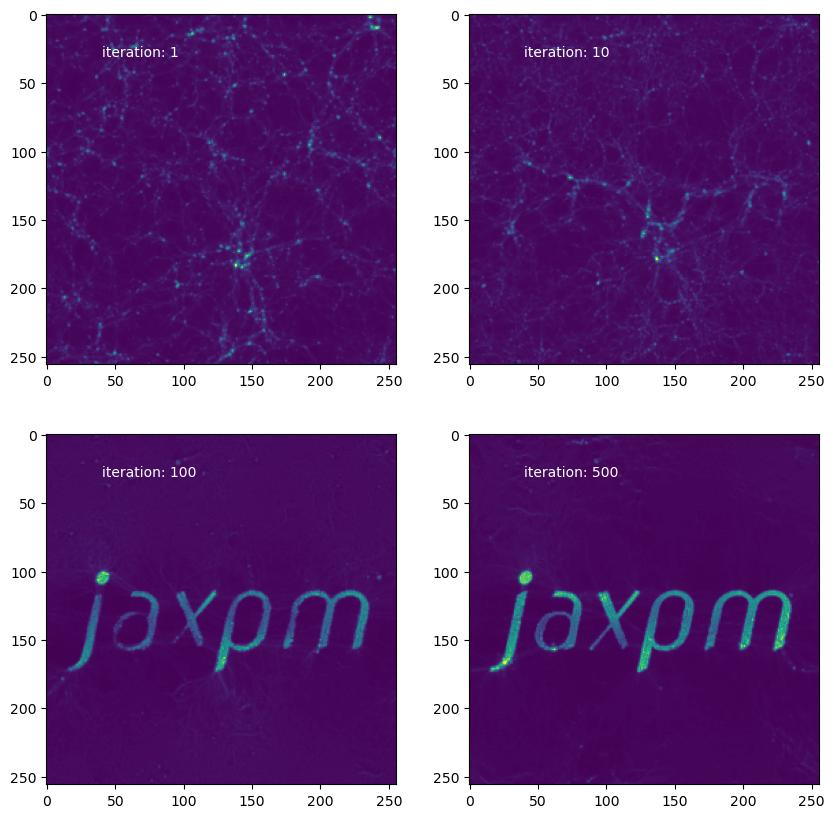

In [23]:
fig, axes  = plt.subplots(2,2, figsize=(10,10))
vmax=-0.9996
vmin=-1.0
axes[0,0].imshow(res0, vmax=vmax,vmin=vmin)
axes[0,1].imshow(res1, vmax=vmax,vmin=vmin)
axes[1,0].imshow(res2, vmax=vmax,vmin=vmin)
axes[1,1].imshow(res3, vmax=vmax,vmin=vmin)
ind=0
iterlist=[1, 10, 100, 500]
for i in range(2):
    for j in range(2):
        axes[i,j].text(40, 30, "iteration: {0}".format(iterlist[ind]), c="w")
        ind+=1

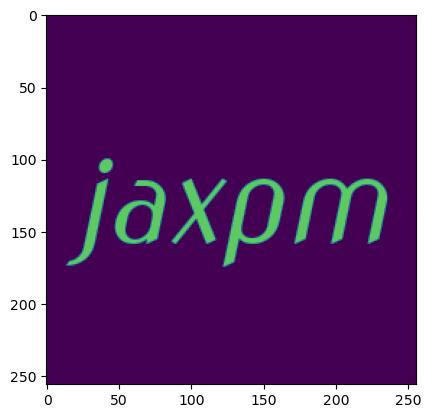

In [25]:
plt.imshow(im_tgt, vmax=vmax, vmin=vmin)

## Compare with Nbody simulation 

In [6]:
import numpy as np
import readgadget

# input files
snapshot = '/project/chto/chto/Qujote/Fiducial/snapdir/0/ICs_chto/////ics'
ptype    = [1] #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)

# read header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)
init_chto = readgadget.read_block("/project/chto/chto/Qujote/Fiducial/snapdir/0/ics_256_init", "POS ", ptype)#positions in Mpc/h

# read positions, velocities and IDs of the particles
disp_chto = readgadget.read_block(snapshot, "POS ", ptype)/1000#positions in Mpc/h
vel_chto = readgadget.read_block(snapshot, "VEL ", ptype)     #peculiar velocities in km/s
ids_chto = readgadget.read_block(snapshot, "ID  ", ptype)   

In [7]:
cosmo_in = [0.3175, 0.049, 0.6711, 0.9624, 0.834]#Omega_m                 Omega_b                  h                        n_s                      sigma_8


In [8]:
#k = jnp.logspace(-4, 1, 128)
nmesh = round(len(disp_chto)**(1/3))
mesh_shape = [nmesh, nmesh, nmesh]
box_size = [BoxSize, BoxSize, BoxSize]

In [ ]:
particles = init_chto.astype(np.float64)
# Initial displacement

cosmo = jc.Cosmology(Omega_c=cosmo_in[0]-cosmo_in[1], Omega_b=cosmo_in[1], h=cosmo_in[2], sigma8 = cosmo_in[4], n_s=cosmo_in[3],
                      Omega_k=0., w0=-1., wa=0.)
ain=np.atleast_1d(1)
_ =  growth_rate_second(cosmo,ain)
_ = growth_rate(cosmo, ain)
_ = growth_factor(cosmo, ain)
jc.background.radial_comoving_distance(cosmo, ain)
    

dx = disp_chto.astype(np.float64)/BoxSize*nmesh
dt0= 0.01
p= (vel_chto.astype(np.float64))*header.time/100/BoxSize*nmesh#/cosmo.h





conf = Configuration(mesh_shape=[nmesh, nmesh, nmesh], 
                     snapshots= [1],
                     BoxSize=box_size, 
                     initial_t0=header.time,
                     final_time = 1,
                     density_plane_npix = nmesh,
                     dt0=dt0)



ode_fn = tree.map(
        FPMODE,
        symplectic_ode(conf.mesh_shape, paint_absolute_pos=True)
)
solver = FPMLeapFrog(initial_t0=conf.initial_t0, final_t1=conf.final_time)
stepsize_controller = ConstantStepSize()

initforce = pm_forces(
        init_chto/conf.BoxSize*conf.mesh_shape[0]/1000+dx,
        mesh_shape=mesh_shape,
        paint_absolute_pos=True,
    )* 1.5* cosmo.Omega_m  

y0= jnp.stack([init_chto/BoxSize*nmesh/1000+dx, p,initforce], axis=0)

res = diffeqsolve(ode_fn,solver,\
                  t0=conf.initial_t0,\
                  t1=conf.final_time,\
                  dt0=conf.dt0,\
                  y0=y0,
                  args=[cosmo, cosmo._workspace, conf.initial_t0, conf, 0, 0],\
                  saveat=SaveAt(t1=True),
                  stepsize_controller=stepsize_controller,adjoint=diffrax.ReversibleAdjoint())


/project/chto/chto/anaconda/newenv4/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [ ]:
res

In [ ]:
from jaxpm.plotting import plot_fields_single_projection
fields={}
field = res.ys[0][0]
fields[f"a=1"] = jnp.log10(cic_paint(jnp.zeros(mesh_shape) , field)+1)
plot_fields_single_projection(fields)


# Check powerspectra 

In [19]:
import numpy as np
import readgadget
import MAS_library as MASL

In [20]:
#snapshot = '/project/chto/chto/Qujote/Fiducial/snapdir/0/ICs/ics' #location of the snapshot

snapshot = '/project/chto/chto/Qujote/Fiducial/snapdir/0/snapdir_004/snap_004' #location of the snapshot
grid     = 1024  #the density field will have grid^3 voxels
MAS      = 'CIC'  #Mass-assignment scheme:'NGP', 'CIC', 'TSC', 'PCS'
verbose  = True   #whether to print information about the progress
ptype    = [1]    #[1](CDM), [2](neutrinos) or [1,2](CDM+neutrinos)
# read header
header   = readgadget.header(snapshot)
BoxSize  = header.boxsize/1e3  #Mpc/h
redshift = header.redshift     #redshift of the snapshot
#Masses   = header.massarr*1e10 #Masses of the particles in Msun/h

# read positions, velocities and IDs of the particles
pos = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
delta = np.zeros((grid,grid,grid), dtype=np.float32)
# construct 3D density field
MASL.MA(pos, delta, BoxSize, MAS, verbose=verbose)
delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0

print('%.3f < delta < %.3f'%(np.min(delta), np.max(delta)))
print('<delta> = %.3f'%np.mean(delta))
print('shape of the matrix:', delta.shape)
print('density field data type:', delta.dtype)



Using CIC mass assignment scheme
Time taken = 37.533 seconds

-1.000 < delta < 4780.165
<delta> = 0.000
shape of the matrix: (1024, 1024, 1024)
density field data type: float32


In [21]:
# compute power spectrum
import Pk_library as PKL
axis=0
threads=1
Pk = PKL.Pk(delta, BoxSize, axis, MAS, threads, verbose)
# Pk is a python class containing the 1D, 2D and 3D power spectra, that can be retrieved as

# 1D P(k)
k1D      = Pk.k1D
Pk1D     = Pk.Pk1D
Nmodes1D = Pk.Nmodes1D


Computing power spectrum of the field...
Time to complete loop = 34.68
Time taken = 57.62 seconds


In [22]:
def get_delta(pos_in):
    delta = np.zeros((grid,grid,grid), dtype=np.float32)
    # construct 3D density field
    MASL.MA(pos_in, delta, BoxSize, MAS, verbose=verbose)
    #delta *= Masses[1]
    
    # now check that the mass in the density field is equal to the total mass in the simulation
    #print('%.3e should be equal to\n%.3e'%(np.sum(delta, dtype=np.float64), pos.shape[0]*Masses[1]))
    # at this point, delta contains the effective number of particles in each voxel
    # now compute overdensity and density constrast
    delta /= np.mean(delta, dtype=np.float64);  delta -= 1.0
    return delta

In [23]:
def getpos(sol, boxsize, nmesh):
    return (sol/nmesh*boxsize)%boxsize

In [25]:
delta_jaxpm =get_delta(np.asarray(getpos(res.ys[0][0], BoxSize, nmesh)).astype('float32'))
Pk_jaxpm = PKL.Pk(delta_jaxpm, BoxSize, axis, MAS, threads, verbose)



Using CIC mass assignment scheme
Time taken = 3.972 seconds


Computing power spectrum of the field...
Time to complete loop = 34.78
Time taken = 57.59 seconds


(0.1, 1.5)

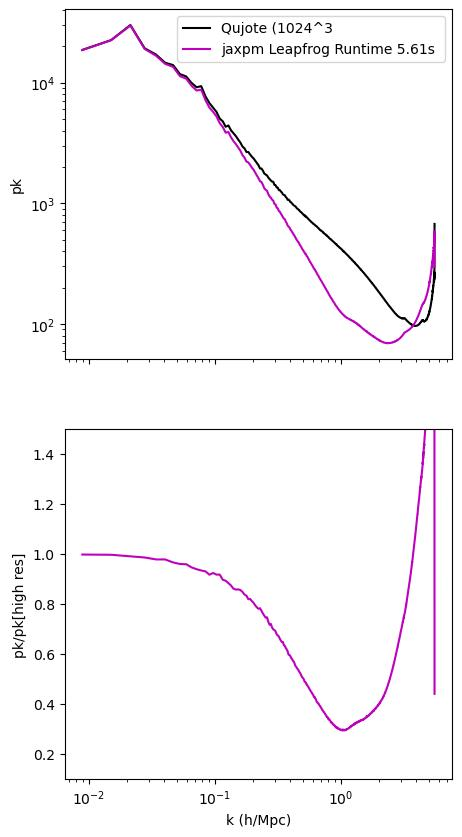

In [26]:
clist = ['k','r','g','b', 'm']
fig, axes=plt.subplots(2,1,figsize=(5,10), sharex=True)
axes[0].plot(Pk.k3D, Pk.Pk[:,0], label="Qujote (1024^3", c=clist[0])
axes[0].plot(Pk_jaxpm.k3D, Pk_jaxpm.Pk[:,0], label="jaxpm Leapfrog Runtime 5.61s ", c=clist[4])

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[1].plot(Pk_jaxpm.k3D, Pk_jaxpm.Pk[:,0]/Pk.Pk[:,0], label="jaxpm Leapfrog", c=clist[4])

axes[0].legend()
axes[0].set_ylabel("pk")
axes[1].set_ylabel("pk/pk[high res]")
axes[1].set_xlabel("k (h/Mpc)")
axes[1].set_ylim(0.1,1.5)
plt.ylim(0.1,1.5)